<img src="risk_diversification.jpg" width="450" height="300" align="right"/>

# Portfolio Theory: Markowitz Model

by Christoph Güttner  

Here, we take a portfolio that contains different stocks and  
precious metals from the last 200 days (10.4.2021). Then, we apply  
Markowitz (1952) portfolio model to find the risk averse efficient    
line between the minimum variance portfolio and the  
tagents portfolio with the maximum sharpe ratio. The sharpe ratio  
in turn is the slop of the Capital Market Line (CML).  
It has the following form:  
  
$R_{P} = I_{RF} + (R_{M} – I_{RF})σ_{P}/σ_{M}$
  
where, $R_{P}$ = expected return of portfolio, $R_{M}$ = return  
on the market portfolio, $I_{RF}$ = risk-free rate of interest,  
$σ_{M}$ = standard deviation of the market portfolio,  
$σ_{P}$ = standard deviation of portfolio.  

Intuitively, the Capital Market Line (CML) describes the respective return  
per unit of additional risk for which a risk averse investor is indifferent.  
The maximum for an risk averse investor is achieved, where the efficient  
frontier is tagent to the sharpe ratio. The risk free asset (zero variance)  
is assumed here (if it exists) to have zero returns.  
  
The main idea of Markowitz appraoch is that the total risk can be divided into a 
systemic risk, which is fixed and external and a second diversfiable risk,  
which can be minimized by finding the optimal portfolio weights under certain  
constraints. The diversifiable risk (variance) and returns have the following  
form:  
x_axes: risk  
  
$\sigma _{x}={\sqrt  {(1-x)^{2}\sigma _{1}^{2}+x^{2}\sigma _{2}^{2}+2\sigma _{1}\sigma _{2}(1-x)x\rho _{{1,2}}}}$  
   
y_axes: annual returns  
  
$\mu _{x} = r(1-x)+\mu _{2}x = r+(\mu _{2}-r)x \mu _{x}$


 


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import datetime as dt
from pandas_datareader import data as pdr

import scipy.optimize as sco

In [52]:
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return stockData, meanReturns, covMatrix

def get_single_performance(stockData):
    returns = stockData.pct_change()
    an_vol = returns.std() * np.sqrt(252)
    an_rt = returns.mean() * 252
    return an_vol, an_rt

def get_portfolio_performance(weights, meanReturns, covMatrix):
    returns = np.sum(meanReturns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(252)
    return std, returns

def portfolio_volatility(weights, meanReturns, covMatrix):
    return get_portfolio_performance(weights, meanReturns, covMatrix)[0]

def get_weights():
    weights = np.random.random(len(meanReturns))
    weights /= np.sum(weights)
    return weights

def neg_sharpe_ratio(weights, meanReturns, covMatrix, risk_free):
    p_var, p_ret = get_portfolio_performance(weights, meanReturns, covMatrix)
    return -(p_ret - risk_free) / p_var

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def get_max_sharpe_ratio( meanReturns, covMatrix, risk_free):
    num_assets = len(meanReturns)
    args = (meanReturns, covMatrix,risk_free )
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                    method='SLSQP', bounds=bounds, constraints=constraints)

    sdp, rp = get_portfolio_performance(result['x'], meanReturns, covMatrix)
    return sdp, rp 


def get_minumum_risk(meanReturns, covMatrix):
    num_assets = len(meanReturns)
    args= (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    sdp_min, rp_min = get_portfolio_performance(result['x'], meanReturns, covMatrix)
    return sdp_min, rp_min

def get_portfolio_sample( weights, meanReturns, covMatrix, num_sample=20_000):
    
    portfolio_return = np.full(shape=(num_sample), fill_value=0.0)
    portfolio_std = np.full(shape=(num_sample), fill_value=0.0)

    for i in range(num_sample):
        weights= get_weights()
        std, returns,= get_portfolio_performance(weights, meanReturns, covMatrix)
        portfolio_return[i] = returns
        portfolio_std[i] = std
    return portfolio_return, portfolio_std


def efficient_return(meanReturns, covMatrix, target):
    num_assets = len(meanReturns)
    args=(meanReturns, covMatrix)

    def portfolio_return(weights):
        return get_portfolio_performance(weights, meanReturns, covMatrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets], args=args, method='SLSQP',  bounds=bounds,                                                                                                    constraints=constraints)
    return result


def calculate_efficient_frontier(meanReturns, covMatrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(meanReturns, covMatrix, ret))
    return efficients

def get_efficient_frontier(rp_min, rp, target):
    Ef_front=[]
    Ef_weights=[]
    ef_front= calculate_efficient_frontier(meanReturns, covMatrix, target)
    Ef_front.append([p['fun'] for p in ef_front])
    Ef_weights.append([p['x'] for p in ef_front])
    return  Ef_front, Ef_weights

def get_efficient_weights(stockList, Ef_weights):
    index=list(range(len(target)-1))
    df_weights = pd.DataFrame(columns=stockList, index=index)

    for i in range(len(target)-1):
        df_weights['AAPL'].iloc[i] = Ef_weights[0][i][0].round(2)
        df_weights['MSFT'].iloc[i] = Ef_weights[0][i][1].round(2)
        df_weights['HEI.DE'].iloc[i] = Ef_weights[0][i][2].round(2)
        df_weights['NKE'].iloc[i] = Ef_weights[0][i][3].round(2)
        df_weights['GC=F'].iloc[i] = Ef_weights[0][i][4].round(2)

    return df_weights.T

def plot_sample(portfolio_std, portfolio_return):
    plt.figure(figsize=(15,5))
    plt.scatter(portfolio_std, portfolio_return, s=2, color='#4E7989', alpha=0.8)
    plt.xlabel('Risk\Variance')
    plt.ylabel('Return')

def plot_efficient_frontier(Ef_front, sdp_min, rp_min,sdp, rp):
    plot_sample(portfolio_std, portfolio_return)
    plt.plot(Ef_front[0],target, linestyle='-.', linewidth = 5, color='#A9011B', label='efficient frontier')
    plt.scatter(sdp, rp, marker='*', color='#E4A826', s=300, label='Maximum Sharp Ratio')
    plt.scatter(sdp_min, rp_min, marker='*', color='#80944E', s=300, label='Minimum Risk')
    plt.legend()

def plot_single_comparison(single_risk, single_return, stockList):
    plot_efficient_frontier(Ef_front, sdp_min, rp_min,sdp, rp)
    plt.scatter(single_risk, single_return, color='#43362A')
    for i, label in enumerate(stockList):
        plt.annotate(label, (single_risk[i], single_return[i]))


## Get Data

In [53]:
stockList= ['AAPL','MSFT','HEI.DE','NKE', 'GC=F']

stocks = [stock for stock in stockList]
endDate = dt.date.today() - dt.timedelta(days=1)

startDate = endDate - dt.timedelta(days=200)

stockData, meanReturns, covMatrix = get_data(stocks, startDate, endDate)
stockData.head()

Symbols           AAPL        MSFT     HEI.DE         NKE         GC=F
Date                                                                  
2020-09-22  111.809998  207.419998  50.639999  116.870003  1898.599976
2020-09-23  107.120003  200.589996  50.599998  127.110001  1859.900024
2020-09-24  108.220001  203.190002  50.000000  124.750000  1868.300049
2020-09-25  112.279999  207.820007  50.060001  124.230003  1857.699951
2020-09-28  114.959999  209.440002  52.180000  124.320000  1872.800049

In [54]:
meanReturns, covMatrix

(Symbols
 AAPL      0.001460
 MSFT      0.001630
 HEI.DE    0.003195
 NKE       0.001190
 GC=F     -0.000548
 dtype: float64,
 Symbols      AAPL      MSFT    HEI.DE       NKE      GC=F
 Symbols                                                  
 AAPL     0.000444  0.000242 -0.000019  0.000075  0.000056
 MSFT     0.000242  0.000262 -0.000008  0.000075  0.000037
 HEI.DE  -0.000019 -0.000008  0.000312  0.000023  0.000005
 NKE      0.000075  0.000075  0.000023  0.000277 -0.000005
 GC=F     0.000056  0.000037  0.000005 -0.000005  0.000123)

### Plot Normalised Stockprices

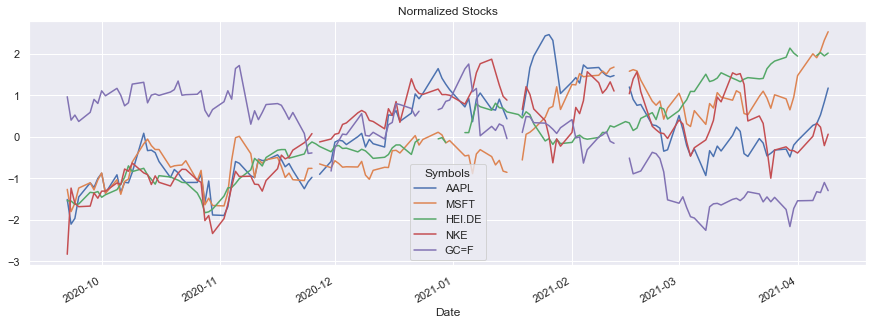

In [55]:

norm_stockData = (stockData-stockData.mean())/stockData.std()
norm_stockData.plot(figsize=(15,5))
plt.title('Normalized Stocks')
plt.show()

## Portfolio-Performance Samples

Text(0.5, 1.0, 'Portfolio Performance Samples')

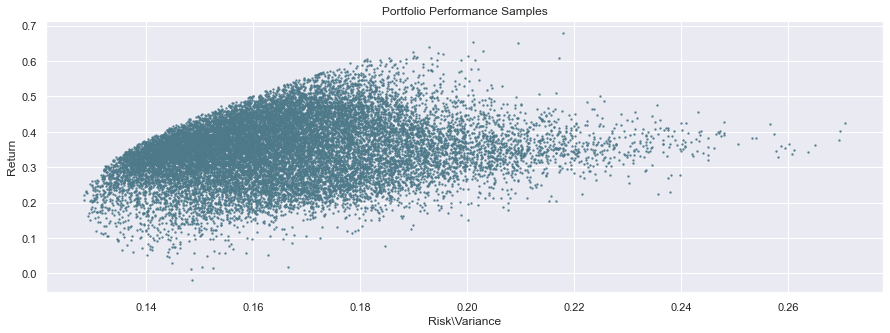

In [62]:
weights = get_weights()
portfolio_return, portfolio_std = get_portfolio_sample(weights, meanReturns, covMatrix,                                                                                                       num_sample=20_000)

plot_sample(portfolio_std, portfolio_return)
plt.title('Portfolio Performance Samples')

## Markowitz Model

### Maximum Sharpe Ratio and Minimum Risk Portfolio

In [63]:
risk_free= 0.0
sdp, rp = get_max_sharpe_ratio(meanReturns, covMatrix, risk_free)
sdp_min, rp_min = get_minumum_risk(meanReturns, covMatrix)



### Get Efficient Frontier

Text(0.5, 1.0, 'Efficient Frontier')

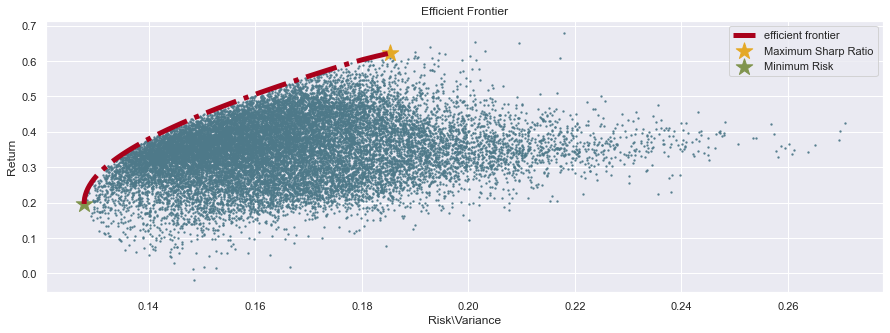

In [64]:
target = np.linspace(rp_min, rp, 50)
Ef_front, Ef_weights = get_efficient_frontier(rp_min, rp, target)

plot_efficient_frontier(Ef_front, sdp_min, rp_min,sdp, rp)
plt.title('Efficient Frontier')

In [65]:

df_weights = get_efficient_weights(stockList, Ef_weights)
df_weights

0     1     2     3     4     5     6     7     8     9   ...    39  \
AAPL       0     0     0     0     0     0     0     0     0     0  ...  0.02   
MSFT    0.13  0.13  0.14  0.14  0.15  0.15  0.16  0.16  0.17  0.17  ...   0.3   
HEI.DE  0.19   0.2   0.2  0.21  0.22  0.22  0.23  0.24  0.24  0.25  ...  0.46   
NKE     0.19  0.19  0.19  0.19  0.19  0.19  0.19  0.19  0.19  0.18  ...  0.16   
GC=F    0.49  0.48  0.47  0.46  0.45  0.43  0.42  0.41   0.4  0.39  ...  0.07   

          40    41    42    43    44    45    46    47    48  
AAPL    0.02  0.02  0.02  0.02  0.02  0.03  0.02  0.02  0.02  
MSFT     0.3   0.3  0.31  0.31  0.31  0.32  0.32  0.32  0.32  
HEI.DE  0.46  0.47  0.48  0.48  0.49   0.5  0.51  0.53  0.55  
NKE     0.16  0.16  0.16  0.16  0.16  0.16  0.14  0.13  0.11  
GC=F    0.06  0.05  0.03  0.02  0.01     0     0     0     0  

[5 rows x 49 columns]

## Compare to single Performance

Text(0.5, 1.0, 'Comparison with Single Performance')

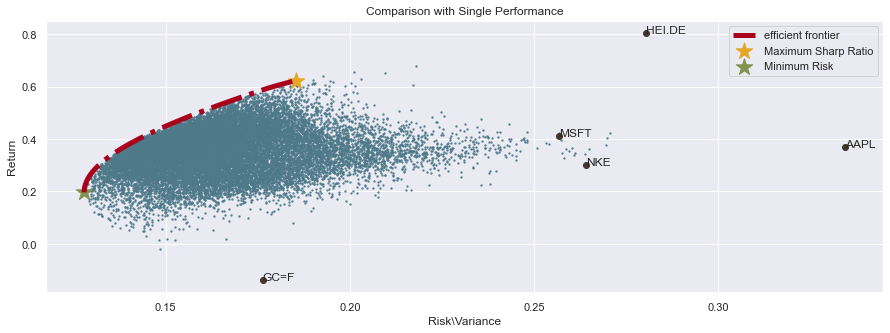

In [66]:
single_risk, single_return = get_single_performance(stockData)

plot_single_comparison(single_risk, single_return, stockList)
plt.title('Comparison with Single Performance')

In [67]:
dictionary={'Risk':single_risk, 'Return':single_return}
df_stocks=pd.DataFrame(dictionary, index=stockList)
df_stocks

Risk    Return
AAPL    0.334428  0.367980
MSFT    0.256781  0.410749
HEI.DE  0.280285  0.805041
NKE     0.264028  0.299980
GC=F    0.176388 -0.137996